# Differential abundance testing on MS whole celltypes

## 1. Prepare analysis environment

In [1]:
## 1.1 Load libraries
library(stringr)
library(Seurat)
library(miloR)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(qs)
library(BiocParallel)
register(MulticoreParam(workers = 4, progressbar = TRUE))

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject

Loading required package: edgeR

Loading required package: limma

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, 

In [2]:
## 1.2 Load data
scRNA <- readRDS("~/2025.LifeScienceAlliance/scRNA.combined_datas5_addcelltype_filtered_2025.RDS")

In [4]:
## 1.3 Set working path
setwd("~/2025.LifeScienceAlliance/01.DA_analysis/01.DA_analysis_whole_celltypes/")

## 2. Data preprocessing

In [5]:
table(scRNA$Lregion_sym)


     CA CA edge      CI CI edge Control    NAWM 
  17576   20099    6947   14790   34371   33886 

In [6]:
scRNA$sample <- paste0(scRNA$Sample_title,"_",scRNA$Lregion_sym)

In [7]:
scRNA$CellType[which(scRNA$CellType == "Astrocytes")] <- "AST"
scRNA$CellType[which(scRNA$CellType == "Endothelial_cells")] <- "Endo&Per"
scRNA$CellType[which(scRNA$CellType == "Excitatory_neurons")] <- "Ex-Neuron"
scRNA$CellType[which(scRNA$CellType == "Immune_cells")] <- "Imm"
scRNA$CellType[which(scRNA$CellType == "Inhibitory_neurons")] <- "In-Neuron"
scRNA$CellType[which(scRNA$CellType == "Microglia_Macrophages")] <- "MG"
scRNA$CellType[which(scRNA$CellType == "Oligodendrocytes")] <- "OL"
scRNA$CellType[which(scRNA$CellType == "OPCs")] <- "OPC"
scRNA$CellType[which(scRNA$CellType == "Vascular_cells")] <- "Vasc"

In [8]:
table(scRNA$CellType)


      AST  Endo&Per Ex-Neuron       Imm In-Neuron        MG        OL       OPC 
    13886      2203     17092       614     11644      7985     67206      6616 
     Vasc 
      423 

In [ ]:
# Define sample combinations
sample_combinations <- list(
  c("CA", "Control"),
  c("CA edge", "Control"),
  c("CI", "Control"),
  c("CI edge", "Control"),
  c("NAWM", "Control")
)

## 3. Differential abundance testing

Constructing kNN graph with k:15

Checking valid object

Checking meta.data validity

Counting cells in neighbourhoods

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting

Converting CellType to factor...



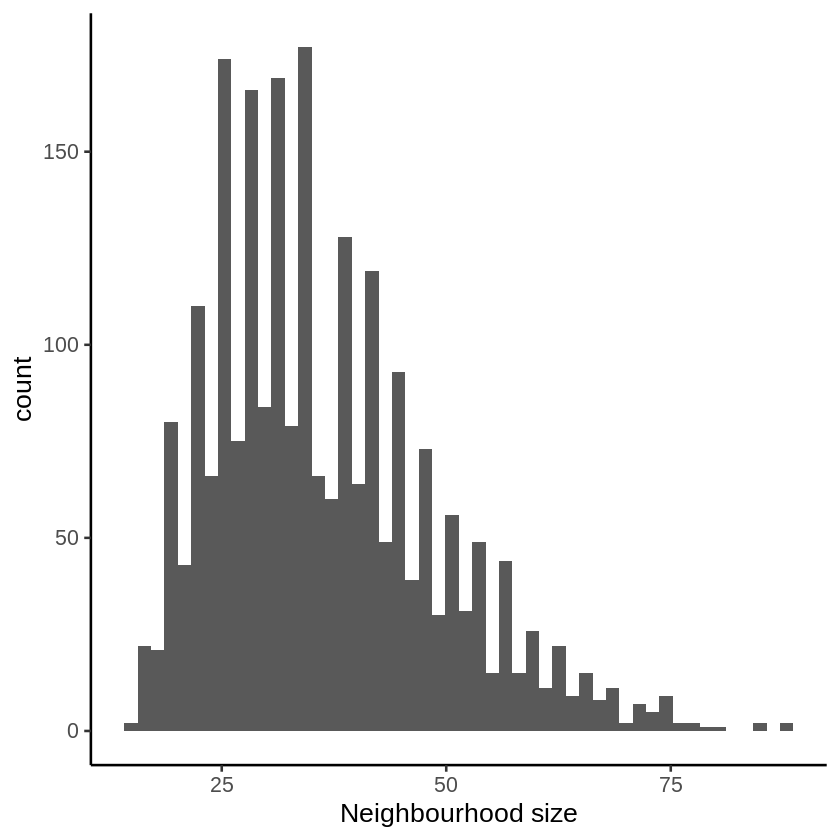

Converting group.by to factor...



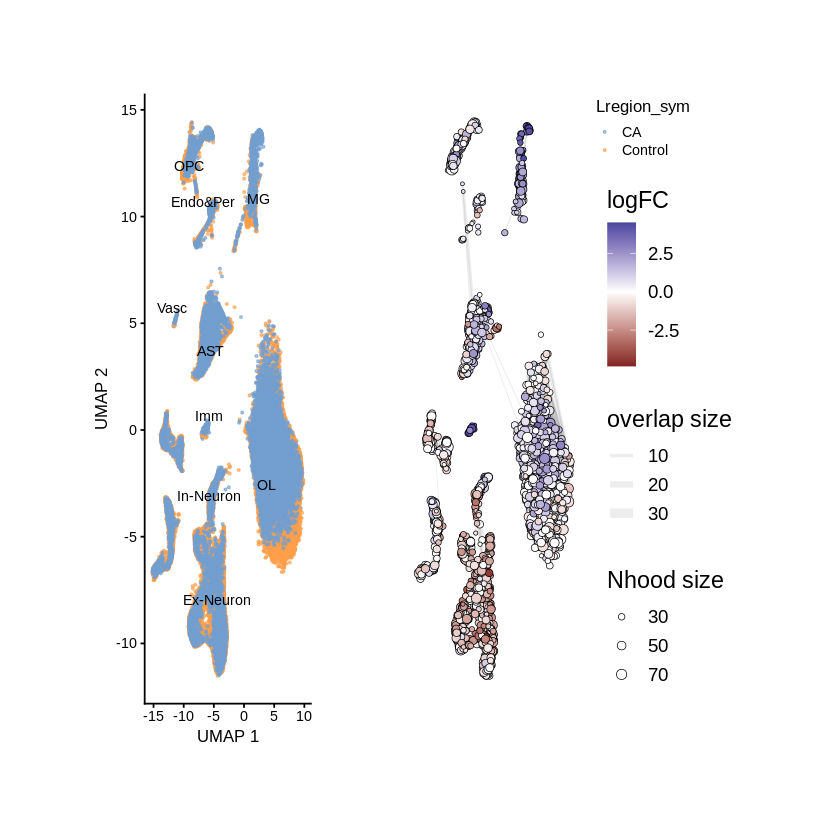

Constructing kNN graph with k:15

Checking valid object



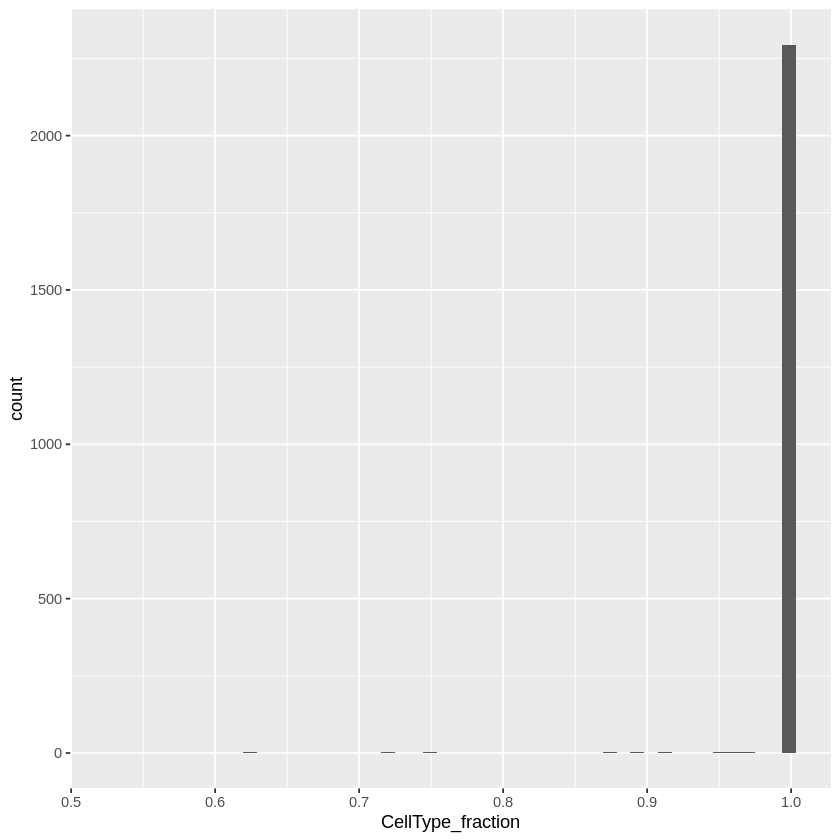

Checking meta.data validity

Counting cells in neighbourhoods

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



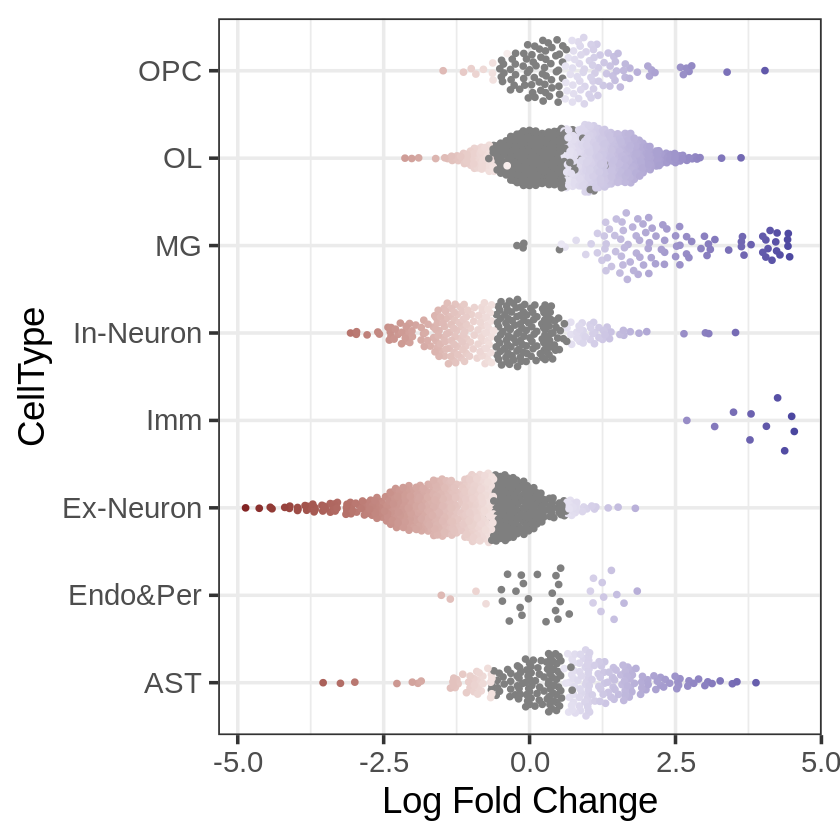

Converting CellType to factor...



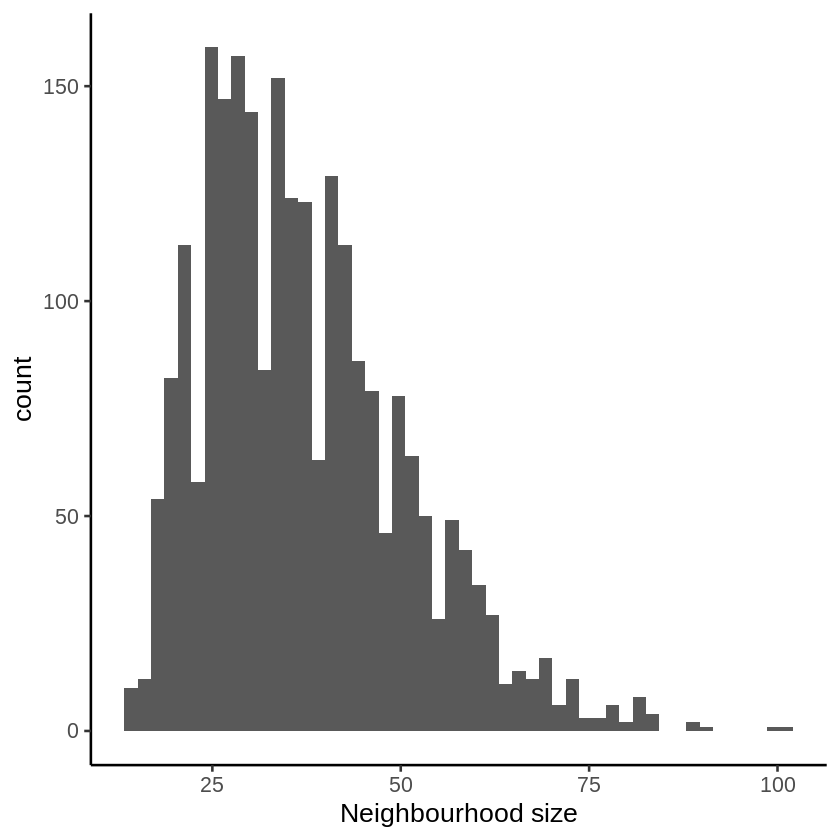

Converting group.by to factor...



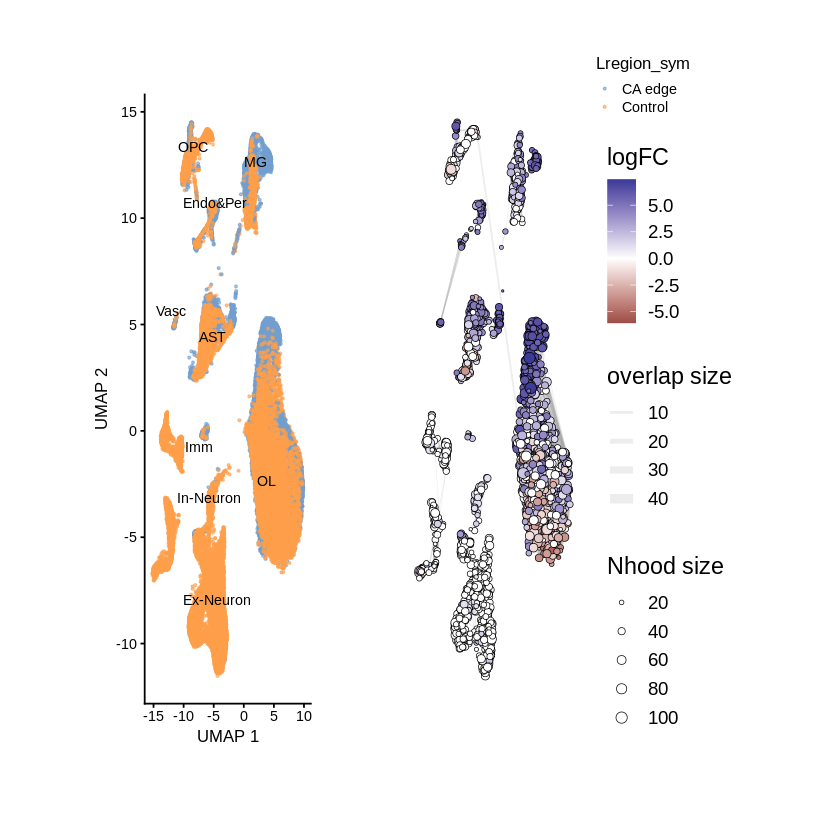

Constructing kNN graph with k:15

Checking valid object



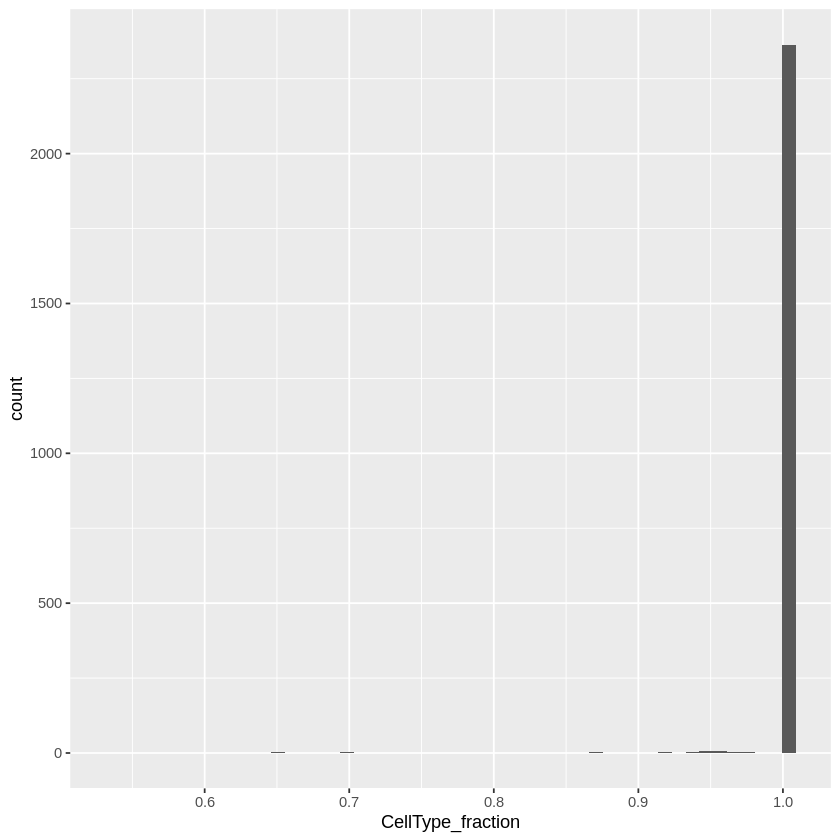

Checking meta.data validity

Counting cells in neighbourhoods

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



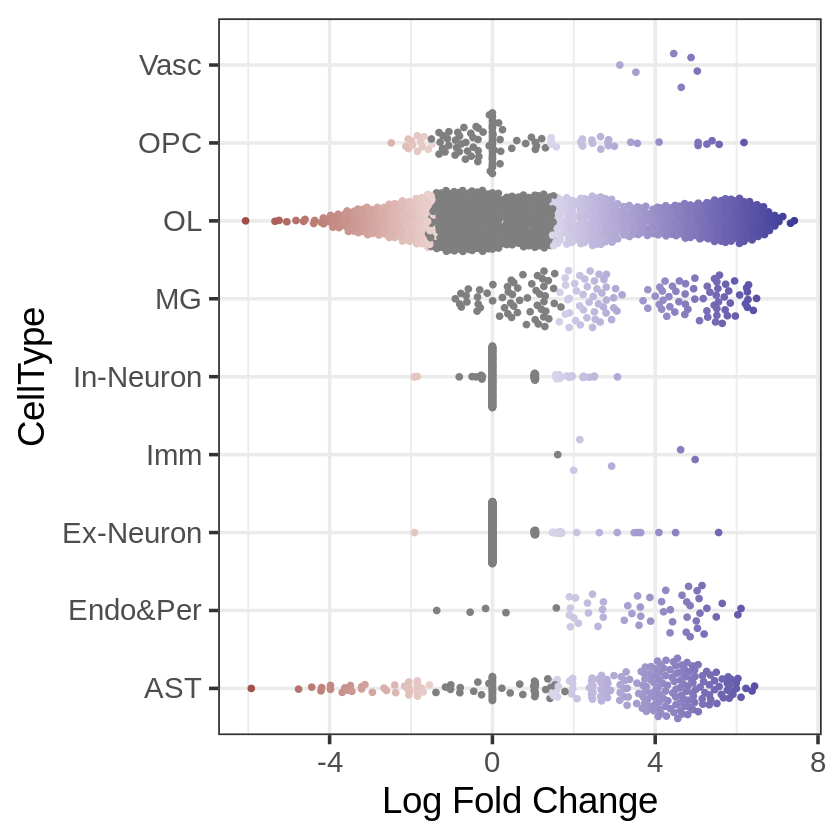

Converting CellType to factor...



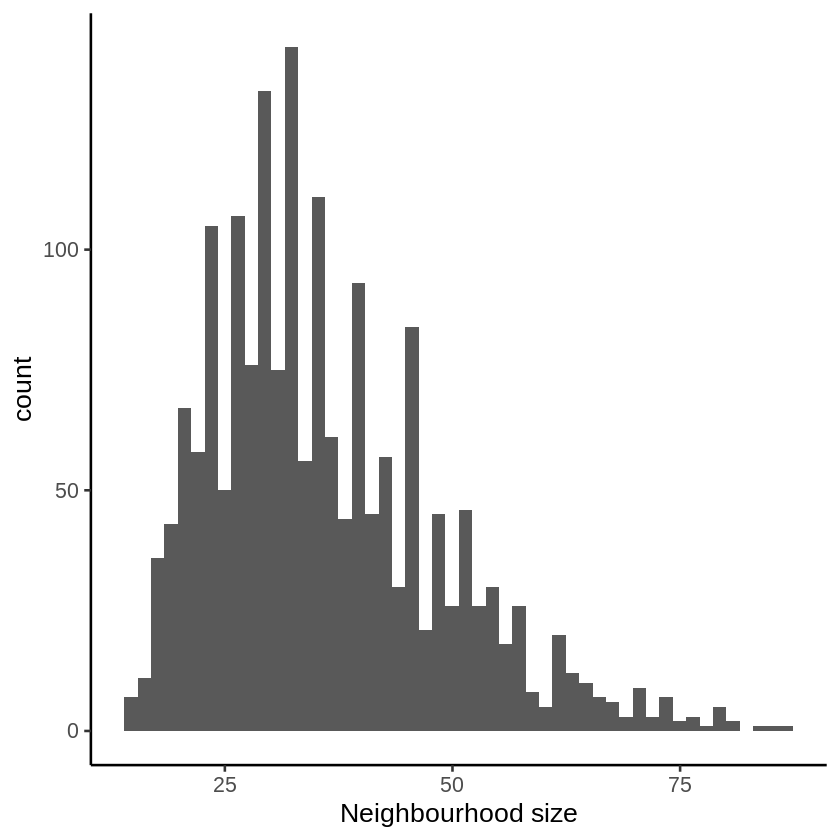

Converting group.by to factor...



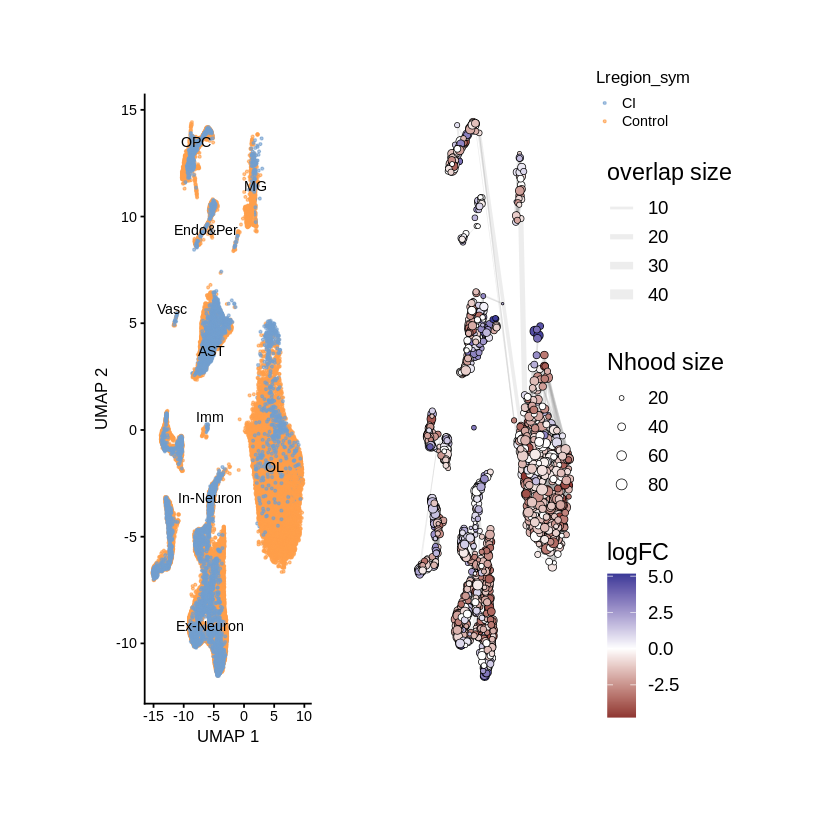

Constructing kNN graph with k:15

Checking valid object



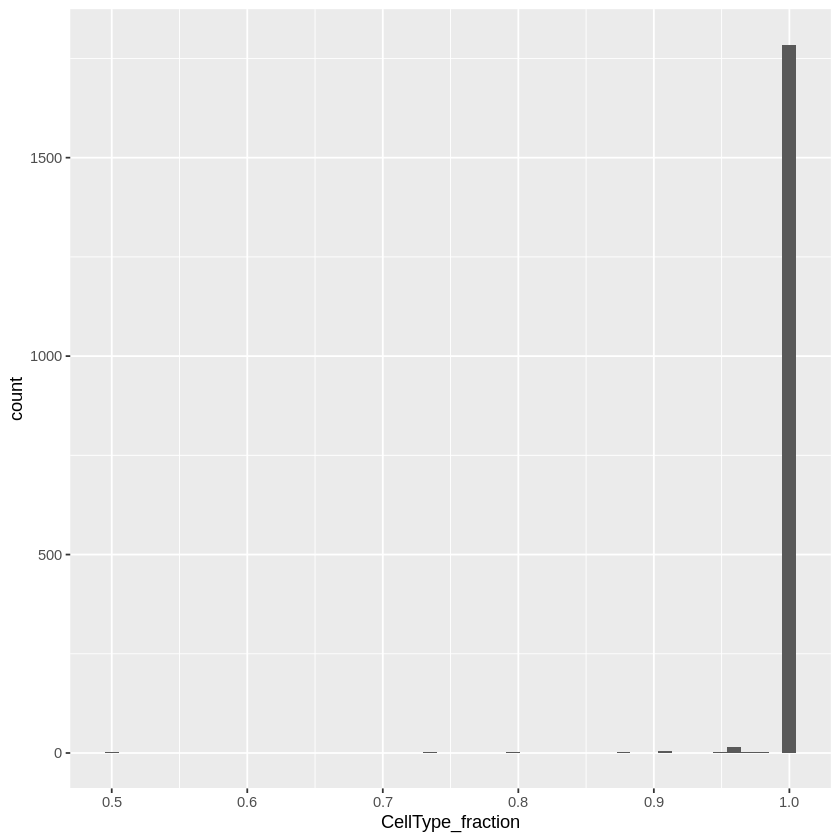

Checking meta.data validity

Counting cells in neighbourhoods

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



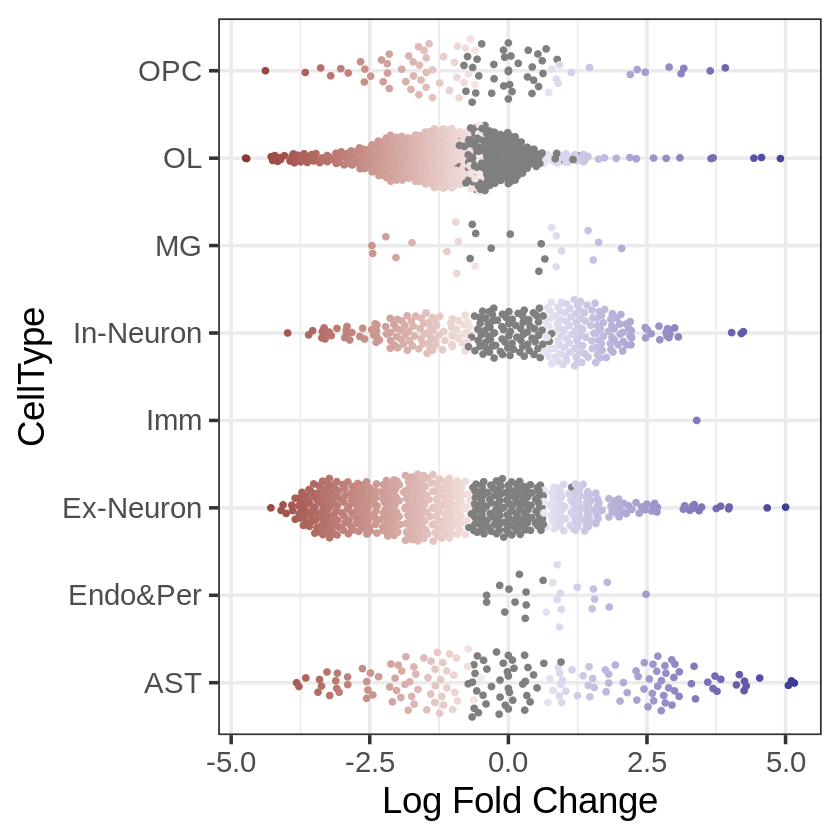

Converting CellType to factor...



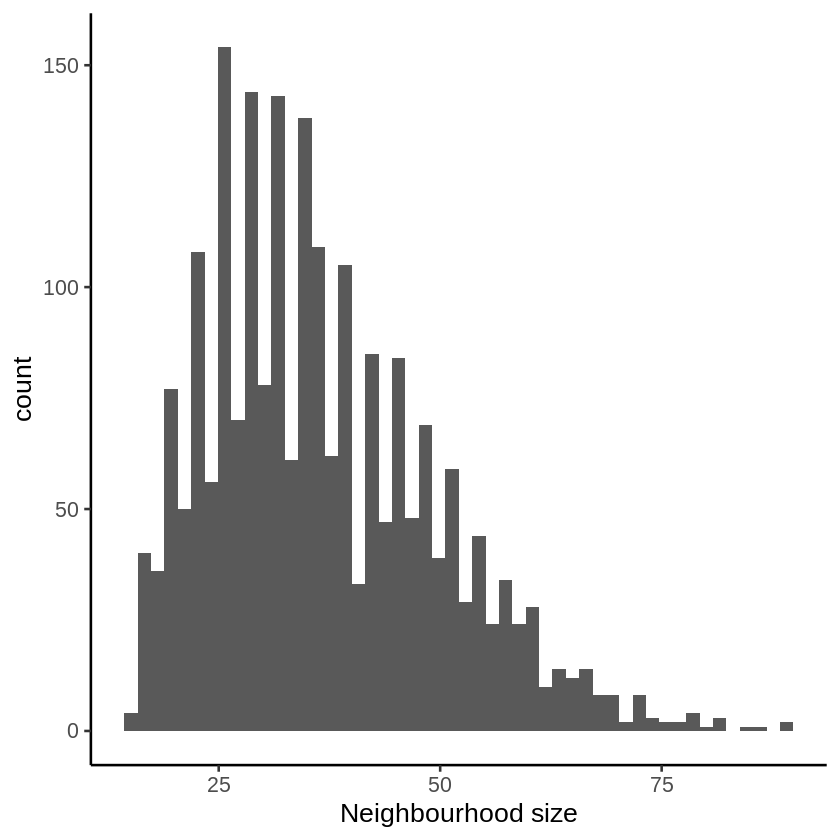

Converting group.by to factor...



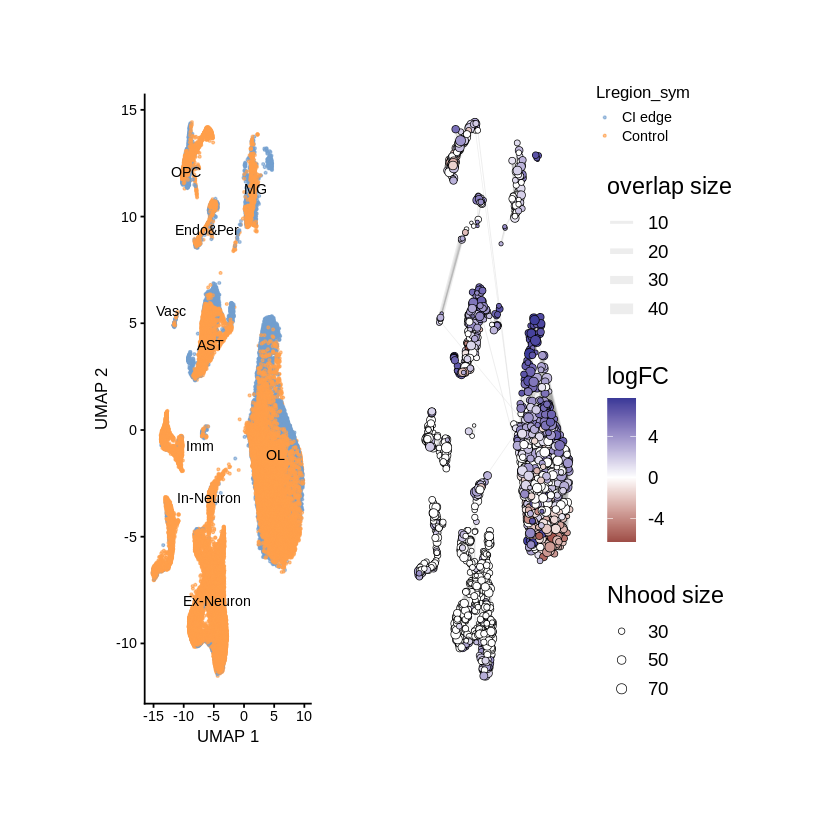

Constructing kNN graph with k:15

Checking valid object



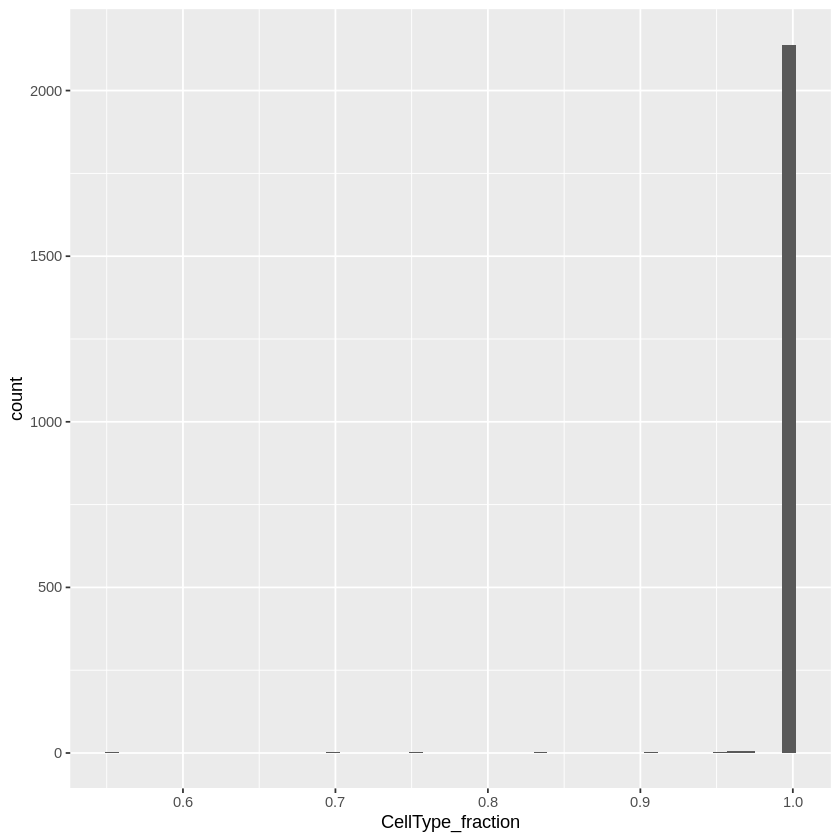

Checking meta.data validity

Counting cells in neighbourhoods



In [ ]:
for (samples in sample_combinations) {
  # Extract sample
  scRNA_sub <- subset(scRNA, subset = Lregion_sym %in% samples)
  
  # Gets the unique orig.ident value
  unique_orig_ident <- unique(scRNA_sub$orig.ident)
  
  # Set the batch column
  scRNA_sub$batch <- ""
  for (i in seq_along(unique_orig_ident)) {
    scRNA_sub$batch[which(scRNA_sub$orig.ident == unique_orig_ident[i])] <- as.character(i)
  }

  # Update meta.data
  dat <- scRNA_sub@meta.data
  dat$group <- ifelse(grepl("Control", dat$sample), "con", "treat")
  scRNA_sub@meta.data <- dat

  # Convert to SingleCellExperiment object
  scRNA_pre <- as.SingleCellExperiment(scRNA_sub)
  
  # Adds the dimension reduction result to the object
  pca_embeddings <- Embeddings(scRNA_sub, "pca")
  umap_embeddings <- Embeddings(scRNA_sub, "umap")
  reducedDims(scRNA_pre) <- SimpleList(PCA = pca_embeddings, UMAP = umap_embeddings)
  
  # 3.1 Create a Milo object
  scRNA_pre <- Milo(scRNA_pre)  
  
  # 3.2 Construct KNN graph
  scRNA_pre <- buildGraph(scRNA_pre, k = 15, d = 15, reduced.dim = "PCA")
  
  # 3.3 Defining representative neighbourhoods on the KNN graph
  scRNA_pre <- makeNhoods(scRNA_pre, prop = 0.05, k = 15, d = 15, refined = TRUE, reduced_dims = "PCA")
  
  print(plotNhoodSizeHist(scRNA_pre))
  
  # Save image to file
  #nhoodsize_plot <- plotNhoodSizeHist(scRNA_pre)
  #pdf_filename <- paste0("scType_NhoodSizeHist_Plot_", samples[1], "-Ctl.pdf")
  #ggsave(pdf_filename, nhoodsize_plot, width = 5, height = 5)

  # 3.4 Counting cells in neighbourhoods
  scRNA_pre <- countCells(scRNA_pre, 
                          meta.data = as.data.frame(colData(scRNA_pre)),
                          sample="sample")

# colData(scRNA_pre) - metadata
# sample - sample number
  
  # 3.6 Computing neighbourhood connectivity
  scRNA_pre <- calcNhoodDistance(scRNA_pre, d = 15, reduced.dim = "PCA")
  
  # 3.5 Defining experimental design
  scRNA_design <- data.frame(colData(scRNA_pre))[, c("sample", "group", "batch")]
  scRNA_design <- distinct(scRNA_design)
  rownames(scRNA_design) <- scRNA_design$sample
  
  # 检测结果
  da_results <- testNhoods(scRNA_pre, design = ~ batch + group, design.df = scRNA_design)
  head(da_results)

  da_results %>%
    arrange(SpatialFDR) %>%
    head() 


  # Save da_results
  #da_results_filename <- paste0("da_results_", samples[1], "_Ctl.rds")
  #saveRDS(da_results, da_results_filename)
  
  # Save da_results
  #da_results_filename <- paste0("da_results_", samples[1], "_Ctl.csv")
  #write.csv(da_results, da_results_filename, row.names = FALSE)
  
  # 4. Inspecting DA testing results
  ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

  ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
    geom_point() +
    geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)


  scRNA_pre <- buildNhoodGraph(scRNA_pre)

  # Plot single-cell UMAP
  umap_pl <- plotReducedDim(scRNA_pre, dimred = "UMAP", 
                            colour_by = "Lregion_sym", text_by = "CellType", 
                            text_size = 3, point_size = 0.5) + guides(fill = "none")
 
  nh_graph_pl <- plotNhoodGraphDA(scRNA_pre, da_results, layout = "UMAP", alpha = 0.9)
  
  combined_plot <- umap_pl + nh_graph_pl + plot_layout(guides = "collect")
  combined_plot <- combined_plot & theme(plot.margin = unit(c(1, 1, 1, 1), "cm"))
  print(combined_plot)
  # Save image to file
  #pdf_filename <- paste0("scType_Neighood_Plot_", samples[1], "-Ctl.pdf")
  #ggsave(pdf_filename, combined_plot, width = 10, height = 5)
  
  # Annotate Nhoods to cell types
  da_results <- annotateNhoods(scRNA_pre, da_results, coldata_col = "CellType")
  head(da_results)
  # Save da_results
  #da_results_filename <- paste0("da_results_", samples[1], "_anno_Ctl.rds")
  #saveRDS(da_results, da_results_filename)
  
  # Save da_results
  #da_results_filename <- paste0("da_results_", samples[1], "_anno_Ctl.csv")
  #write.csv(da_results, da_results_filename, row.names = FALSE)

  HistogramPlot <- ggplot(da_results, aes(CellType_fraction)) + geom_histogram(bins=50)
  print(HistogramPlot)
  #histogram_pdf_filename <- paste0("scType_Histogram_Plot_", samples[1], "-Ctl.pdf")
  #ggsave(histogram_pdf_filename, HistogramPlot, width = 10, height = 9)

  # Save DA beeswarm 
  DAbeeswarmPlot <- plotDAbeeswarm(da_results, group.by = "CellType", alpha = 0.7)
  print(DAbeeswarmPlot)
  #beeswarm_pdf_filename <- paste0("scType_DAbeeswarm_Plot_", samples[1], "-Ctl.pdf")
  #ggsave(beeswarm_pdf_filename, DAbeeswarmPlot, width = 10, height = 9)

  #da_results$celltype <- ifelse(da_results$CellType_fraction < 0.7, "Mixed", da_results$celltype)
  #plotDAbeeswarm(da_results, group.by = "CellType")

}